<a href="https://colab.research.google.com/github/caro-vergara-tamara/where-to-live/blob/main/read_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from typing import Tuple, Dict

In [2]:
from preparing_data.immo_preprocessing import select_and_rename_immo_columns
from preparing_data.immo_preprocessing import add_geo_info
from preparing_data.immo_preprocessing import backfill_geo_from_cd_stat_sector
from preparing_data.immo_preprocessing import fill_hierarchy_by_type_year
from preparing_data.immo_preprocessing import expand_to_synthetic_transactions

In [4]:
# help(select_and_rename_immo_columns)

In [3]:
# Import immo database
immo = pd.read_excel('data/TF_IMMO_SECTOR.xlsx', engine='openpyxl')
# immo.columns

In [23]:
immo.head

<bound method NDFrame.head of        cd_stat_sector  cd_year cd_type  \
0           11001A00-     2013    B001   
1           11001A00-     2014    B001   
2           11001A00-     2015    B001   
3           11001A00-     2016    B001   
4           11001A00-     2017    B001   
...               ...      ...     ...   
456844  93090_UNKNOWN     2013    B00A   
456845  93090_UNKNOWN     2014    B00A   
456846  93090_UNKNOWN     2015    B00A   
456847  93090_UNKNOWN     2016    B00A   
456848  93090_UNKNOWN     2021    B00A   

                                               CD_TYPE_FR   n       p25  \
0       Maisons avec 2 ou 3 façades (type fermé + type...  17  190000.0   
1       Maisons avec 2 ou 3 façades (type fermé + type...  20  197500.0   
2       Maisons avec 2 ou 3 façades (type fermé + type...  14       NaN   
3       Maisons avec 2 ou 3 façades (type fermé + type...  16       NaN   
4       Maisons avec 2 ou 3 façades (type fermé + type...  20  240000.0   
...            

In [4]:
immo = select_and_rename_immo_columns(immo)

In [7]:
# immo.columns # good good good

In [5]:
immo, diagnostics  = add_geo_info(immo)

In [9]:
 #diagnostics

In [10]:
# immo.isnull().sum()          

In [11]:
# immo.columns

In [6]:
# Or let it load from parquet path:
full_db, diag = backfill_geo_from_cd_stat_sector(immo)

print(diag)
# Quick check that row count is preserved
assert diag["shape_unchanged"], "Row count changed unexpectedly."

{'rows_total': 456849, 'initial_missing_sub_munty': 10034, 'suspicious_rows': 119, 'unknown_rows': 9915, 'remaining_missing_sub_munty': 10034, 'unresolved_key_samples': ['11002J81-', '11002J901', '11002J912', '11002J923', '11002J932', '11002J94-', '11002P21-', '11002Q2PA', '52043A10-', '52043B01-', '52063A372', '62108F09-', '62108F19-', '11001_UNKNOWN', '11002_UNKNOWN'], 'shape_unchanged': True}


In [7]:
immo = full_db 

In [14]:
# immo.isnull().sum()    

In [15]:
# I want to check if there's a particular year that has more missing information than other, 
immo.groupby("cd_year").apply(lambda x: x.isnull().sum())
# The previous years tend to have more missing data

C:\Users\carol\AppData\Local\Temp\ipykernel_2688\663595424.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  immo.groupby("cd_year").apply(lambda x: x.isnull().sum())


,cd_stat_sector,cd_year,cd_type,CD_TYPE_FR,n,p25,p50,p75,p10,p90,cd_sub_munty,cd_munty_refnis,cd_dstr_refnis,cd_prov_refnis,cd_rgn_refnis
cd_year,,,,,,,,,,,,,,,
2013,0,0,0,0,0,37355,37355,37355,37355,37355,1802,0,0,0,1802
2014,0,0,0,0,0,38534,38534,38534,38534,38534,1812,0,0,0,1812
2015,0,0,0,0,0,38164,38164,38164,38164,38164,1277,0,0,0,1277
2016,0,0,0,0,0,38628,38628,38628,38628,38628,763,0,0,0,763
2017,0,0,0,0,0,38933,38933,38933,38933,38933,669,0,0,0,669
2018,0,0,0,0,0,39681,39681,39681,39681,39681,658,0,0,0,658
2019,0,0,0,0,0,39499,39499,39499,39499,39499,643,0,0,0,643
2020,0,0,0,0,0,39493,39493,39493,39493,39493,543,0,0,0,543
2021,0,0,0,0,0,39901,39901,39901,39901,39901,681,0,0,0,681


In [16]:
immo.groupby('cd_type')["CD_TYPE_FR"].unique()

cd_type
B001    [Maisons avec 2 ou 3 façades (type fermé + typ...
B002    [Maisons avec 4 ou plus de façades (type ouvert)]
B00A    [Toutes les maisons avec 2, 3, 4 ou plus de fa...
B015                                       [Appartements]
Name: CD_TYPE_FR, dtype: object

In [17]:
df = immo.groupby(['cd_type', "cd_year"])["p50"].mean().reset_index()

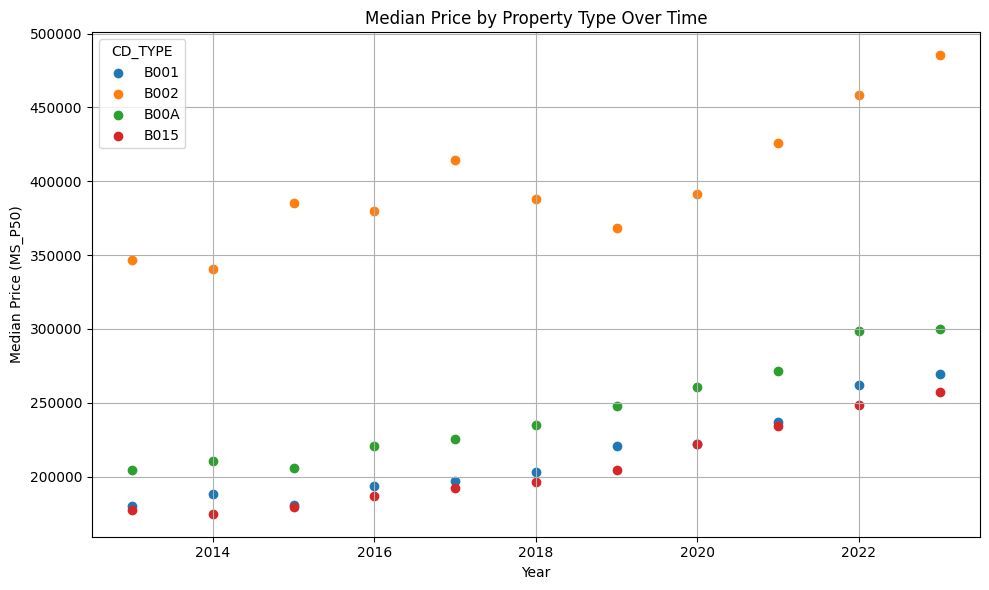

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for cd_type, group in df.groupby('cd_type'):
    plt.scatter(group['cd_year'], group['p50'], label=cd_type)

plt.xlabel("Year")
plt.ylabel("Median Price (MS_P50)")
plt.title("Median Price by Property Type Over Time")
plt.legend(title="CD_TYPE")
plt.grid(True)
plt.tight_layout()
plt.show()


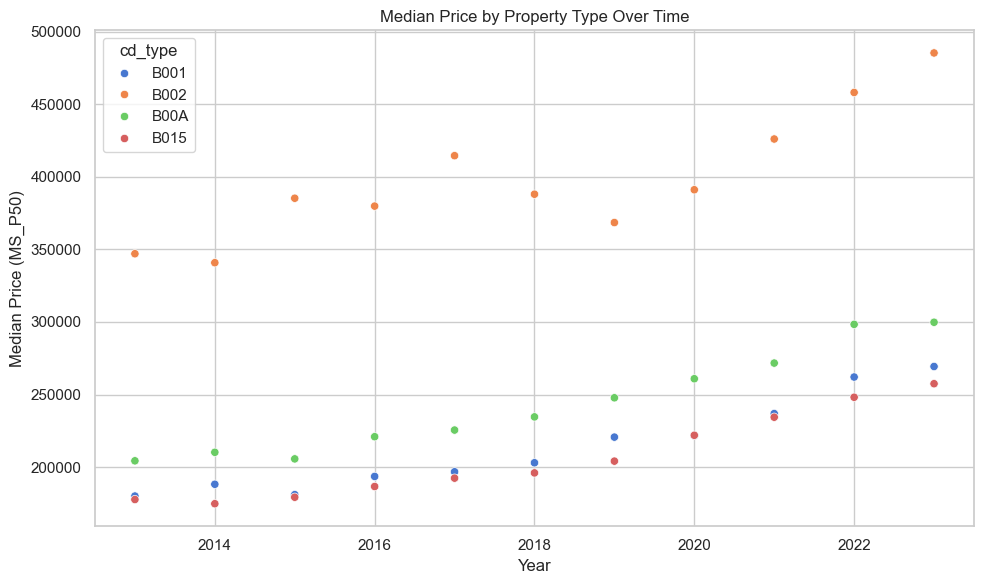

In [19]:
# trying a different library hehe 
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", palette="muted")
sns.scatterplot(data=df, x='cd_year', y='p50', hue='cd_type')

plt.xlabel("Year")
plt.ylabel("Median Price (MS_P50)")
plt.title("Median Price by Property Type Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
immo_original = immo

In [14]:
for pct in ['p10', 'p25', 'p50', 'p75', 'p90']:
    immo = fill_hierarchy_by_type_year(immo, pct)

In [13]:
immo.isnull().sum()

cd_stat_sector         0
cd_year                0
cd_type                0
CD_TYPE_FR             0
n                      0
p25                22512
p50                22512
p75                22512
p10                22512
p90                22512
cd_sub_munty       10034
cd_munty_refnis        0
cd_dstr_refnis         0
cd_prov_refnis         0
cd_rgn_refnis      10034
dtype: int64

In [17]:
immo.shape

(456849, 15)

In [18]:
22512/456849

0.04927667566307467

In [ ]:
# Making some geo_visualizations 

In [21]:
import pandas as pd
import geopandas as gpd
import fiona

# Last 2024 ----

layers_2024 = fiona.listlayers("data/sh_statbel_statistical_sectors_3812_20240101/sh_statbel_statistical_sectors_3812_20240101.sqlite")
print("Available layers 2024:", layers_2024)

# Load one of the layers
gdf_2024 = gpd.read_file("data/sh_statbel_statistical_sectors_3812_20240101/sh_statbel_statistical_sectors_3812_20240101.sqlite", layer=layers_2024[0])  # or manually specify: layer="my_layer_name"
gdf_2024.head()

# Index(['ogc_fid0', 'cd_sector', 'tx_sector_descr_nl', 'tx_sector_descr_fr',
#        'tx_sector_descr_de', 'cd_sub_munty', 'tx_sub_munty_nl',
#        'tx_sub_munty_fr', 'tx_munty_dstr', 'cd_munty_refnis',
#        'tx_munty_descr_nl', 'tx_munty_descr_fr', 'tx_munty_descr_de',
#        'cd_dstr_refnis', 'tx_adm_dstr_descr_nl', 'tx_adm_dstr_descr_fr',
#        'tx_adm_dstr_descr_de', 'cd_prov_refnis', 'tx_prov_descr_nl',
#        'tx_prov_descr_fr', 'tx_prov_descr_de', 'cd_rgn_refnis',
#        'tx_rgn_descr_nl', 'tx_rgn_descr_fr', 'tx_rgn_descr_de', 'cd_country',
#        'cd_nuts_lvl1', 'cd_nuts_lvl2', 'cd_nuts_lvl3', 'ms_area_ha',
#        'ms_perimeter_m', 'dt_situation', 'geometry'],
#       dtype='object')

immo.columns
# Index(['cd_stat_sector', 'cd_year', 'cd_type', 'CD_TYPE_FR', 'n', 'p25', 'p50',
#        'p75', 'p10', 'p90', 'cd_sub_munty', 'cd_munty_refnis',
#        'cd_dstr_refnis', 'cd_prov_refnis', 'cd_rgn_refnis'],
#       dtype='object')


# immo_map = immo.merge(gdf_2024, how="left",   
#                       left_on="cd_stat_sector",   
#                       right_on="cd_sector")


Available layers 2024: ['sh_statbel_statistical_sectors_3812_20240101']


Index(['cd_stat_sector', 'cd_year', 'cd_type', 'CD_TYPE_FR', 'n', 'p25', 'p50',
       'p75', 'p10', 'p90', 'cd_sub_munty', 'cd_munty_refnis',
       'cd_dstr_refnis', 'cd_prov_refnis', 'cd_rgn_refnis'],
      dtype='object')

In [ ]:
immo['cd_year'].unique()

In [22]:
# Just checking that every stat sector only has one value per house :) 

# Filter for 2023
df_2023 = immo[immo["cd_year"] == 2023]

# Count rows per sector
sector_counts = df_2023.groupby(["cd_stat_sector", "cd_type"]).size().reset_index(name="count")
test = df_2023[df_2023["cd_stat_sector"] == "93090A19-"]
test

# Sort descending
sector_counts = sector_counts.sort_values(by="count", ascending=False)

print(sector_counts.head(10))   # Show top 10


  cd_stat_sector cd_type  count
0      11001A00-    B001      1
1      11001A00-    B002      1
2      11001A00-    B00A      1
3      11001A00-    B015      1
4      11001A01-    B001      1
5      11001A01-    B002      1
6      11001A01-    B00A      1
7      11001A01-    B015      1
8      11001A020    B001      1
9      11001A020    B002      1


In [34]:
immo_map_2023 = immo[(immo["cd_year"] == 2023) & (immo["cd_type"] == "B00A")]

# 1. Make sure geometry is available by merging
immo_map_2023 = immo_map_2023.merge(
    gdf_2024.rename(columns={"cd_sector": "cd_stat_sector"}),
    on="cd_stat_sector",
    how="left"
)

# 2. Convert to GeoDataFrame (geometry column comes from gdf_2024)
immo_map_2023 = gpd.GeoDataFrame(immo_map_2023, geometry="geometry", crs=gdf_2024.crs)


(np.float64(508742.46186999604),
 np.float64(806598.0909300037),
 np.float64(510030.49816999957),
 np.float64(755172.514630001))

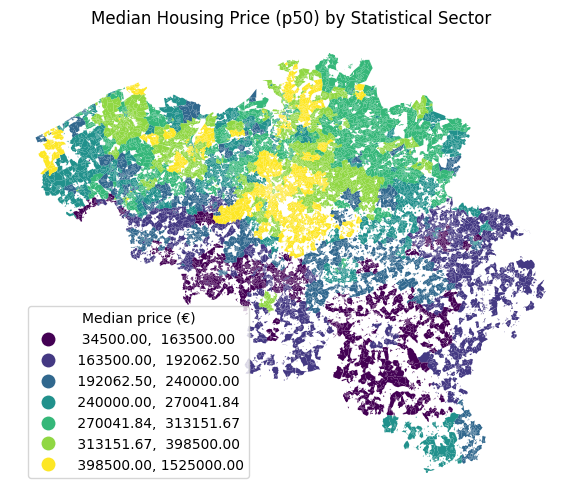

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
immo_map_2023.plot(
    column="p50",
    cmap="viridis",
    scheme="quantiles",  # or "naturalbreaks"
    k=7,
    linewidth=0,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "loc": "lower left",
        "bbox_to_anchor": (0.02, 0.02),   # x, y in axes coords
        "title": "Median price (€)",
        "frameon": True
    },
    ax=ax
)
ax.set_title("Median Housing Price (p50) by Statistical Sector")
ax.axis("off")

In [25]:
# immo_map_2023.columns

Index(['cd_stat_sector', 'cd_year', 'cd_type', 'CD_TYPE_FR', 'n', 'p25', 'p50',
       'p75', 'p10', 'p90', 'cd_sub_munty_x', 'cd_munty_refnis_x',
       'cd_dstr_refnis_x', 'cd_prov_refnis_x', 'cd_rgn_refnis_x', 'ogc_fid0',
       'tx_sector_descr_nl', 'tx_sector_descr_fr', 'tx_sector_descr_de',
       'cd_sub_munty_y', 'tx_sub_munty_nl', 'tx_sub_munty_fr', 'tx_munty_dstr',
       'cd_munty_refnis_y', 'tx_munty_descr_nl', 'tx_munty_descr_fr',
       'tx_munty_descr_de', 'cd_dstr_refnis_y', 'tx_adm_dstr_descr_nl',
       'tx_adm_dstr_descr_fr', 'tx_adm_dstr_descr_de', 'cd_prov_refnis_y',
       'tx_prov_descr_nl', 'tx_prov_descr_fr', 'tx_prov_descr_de',
       'cd_rgn_refnis_y', 'tx_rgn_descr_nl', 'tx_rgn_descr_fr',
       'tx_rgn_descr_de', 'cd_country', 'cd_nuts_lvl1', 'cd_nuts_lvl2',
       'cd_nuts_lvl3', 'ms_area_ha', 'ms_perimeter_m', 'dt_situation',
       'geometry'],
      dtype='object')

In [36]:
# Craeting synthetic real satate sales based on the information of Statbel
synthetic_df = expand_to_synthetic_transactions(immo)

In [37]:
synthetic_df.sample(6)

,cd_stat_sector,cd_year,cd_type,price,source
784397,24134A10-,2022,B001,267506.967197,synthetic
1994722,71004A001,2016,B015,319936.671889,synthetic
2249292,92048A00-,2021,B001,194705.043222,synthetic
1677330,53053L00-,2015,B001,159499.384112,synthetic
1296926,42011B00-,2021,B00A,329846.356271,synthetic
1237624,41027A020,2018,B001,175890.606762,synthetic


In [38]:
synthetic_df.columns

Index(['cd_stat_sector', 'cd_year', 'cd_type', 'price', 'source'], dtype='object')

In [39]:
db = synthetic_df

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Make sure geometry is available by merging
db = db.merge(
    gdf_2024.rename(columns={"cd_sector": "cd_stat_sector"}),
    on="cd_stat_sector",
    how="left"
)

# 2. Convert to GeoDataFrame (geometry column comes from gdf_2024)
db = gpd.GeoDataFrame(db, geometry="geometry", crs=gdf_2024.crs)

# 3. Simple choropleth plot
db_2023 = db[(db['cd_year']==2023) & (db["cd_type"] == "B00A")]



(np.float64(508742.46186999604),
 np.float64(806598.0909300037),
 np.float64(510030.49816999957),
 np.float64(755172.514630001))

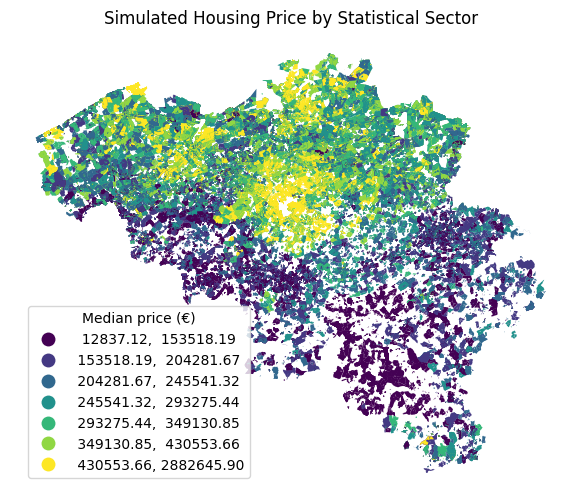

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
db_2023.plot(
    column="price",
    cmap="viridis",
    scheme="quantiles",  # or "naturalbreaks"
    k=7,
    linewidth=0,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "loc": "lower left",
        "bbox_to_anchor": (0.02, 0.02),   # x, y in axes coords
        "title": "Median price (€)",
        "frameon": True
    },
    ax=ax
)
ax.set_title("Simulated Housing Price by Statistical Sector")
ax.axis("off")

In [ ]:
####################################### 
# Hereeee
# ok so, is done, kind of, and for next time I would like to analyze the biggest differences between the real and synthethic distrbution.
# and then is doneee and we go to socieconomical variables